# Analisi dei dati raccolti

## Setup

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

from types import FunctionType

In [2]:
def plotter(dataframes: list, index: str, names: list, space: int) -> None:
    xvalues_int = list()
    xvalues_str = list()
    for name in names:
        xvalues_str.extend(["", name, ""])

    plt.gcf().set_size_inches(10, 6)
    plt.title("Generazione" if "A" in index else "Verifica")
    plt.ylabel("Tempo di esecuzione")
    
    start = 1
    ymax = 0
    for dataframe in dataframes:
        series = dataframe[index]
        ymax = max(ymax, max(series))
        x = [start, start+1, start+2]
        xvalues_int.extend(x)
        plt.bar(x, [series.min(), series.mean(), series.max()])
        start += 5
    
    plt.xticks(xvalues_int, xvalues_str, rotation=90)
    plt.yticks([i for i in range(0, ymax+space, space)])
    plt.grid(axis="y")
    
    plt.show()

In [3]:
PATH = "../asconprfsv12/data/{}.csv"

IMPLEMENTATIONS = [
    "armv7m", "armv7m_small", "bi32", "bi32_armv7m", "bi32_lowreg", "opt32", "ref"
]

armv7m = pd.read_csv(open(PATH.format("armv7m"), "r"), delimiter=";")
armv7m_small = pd.read_csv(open(PATH.format("armv7m_small"), "r"), delimiter=";")
bi32 = pd.read_csv(open(PATH.format("bi32"), "r"), delimiter=";")
bi32_armv7m = pd.read_csv(open(PATH.format("bi32_armv7m"), "r"), delimiter=";")
bi32_lowreg = pd.read_csv(open(PATH.format("bi32_lowreg"), "r"), delimiter=";")
opt32 = pd.read_csv(open(PATH.format("opt32"), "r"), delimiter=";")
ref = pd.read_csv(open(PATH.format("ref"), "r"), delimiter=";")

DATAFRAMES = [
    armv7m, armv7m_small, bi32, bi32_armv7m, bi32_lowreg, opt32, ref
]

INDEX = armv7m.columns

## Grafici

Ogni grafico presente in questo notebook è suddiviso in sette parti, ognuna delle quali contiene una rappresentazione dei dati raccolti durante il testing in fase di generazione o verifica del tag di una data implementazione

Le implementazioni, che vanno a indicizzare l'asse delle X, vengono rappresentate da tre barre:
* la barra di sinistra rappresenta il valore **minimo**
* la barra centrale rappresenta il valore **medio**
* la barra di destra rappresenta il valore **massimo**

I valori sull'asse Y rappresentano il tempo di esecuzione in **microsecondi**

### PT vuoto

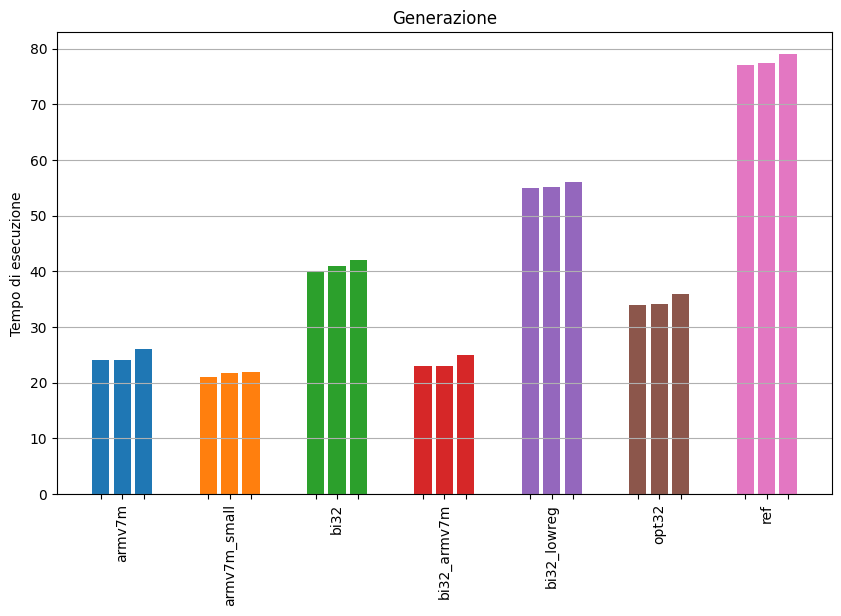

In [4]:
# Generazione tag
plotter(DATAFRAMES, "0B-A", IMPLEMENTATIONS, 10)

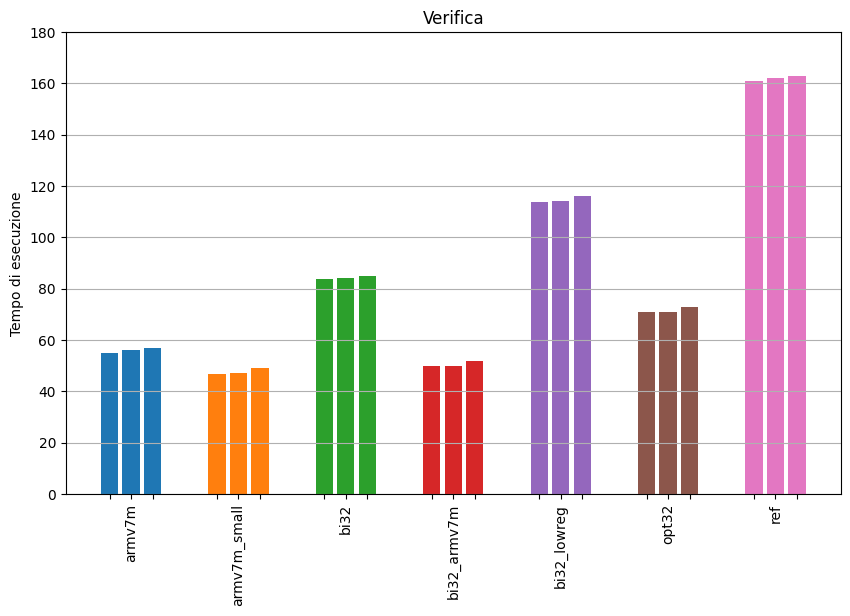

In [5]:
# Verifica tag
plotter(DATAFRAMES, "0B-V", IMPLEMENTATIONS, 20)

### PT 8 byte

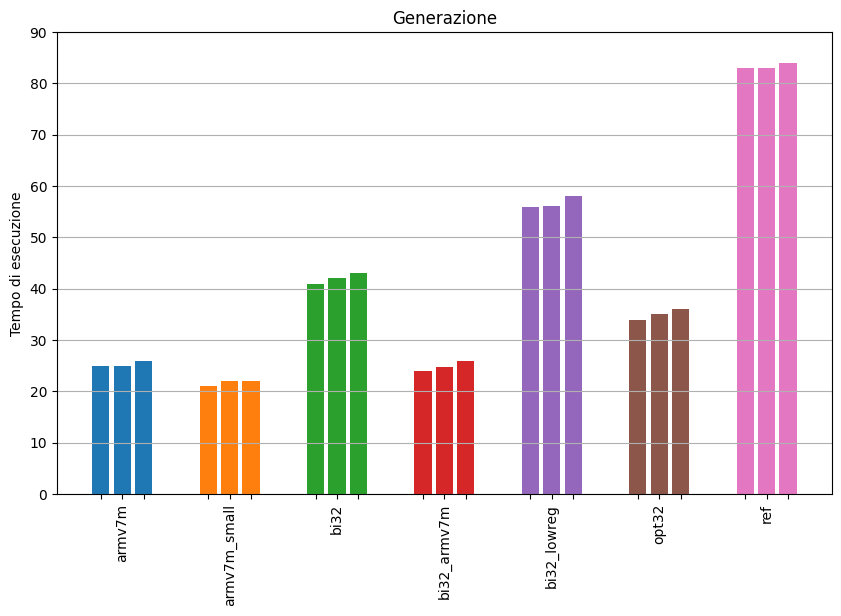

In [6]:
# Generazione tag
plotter(DATAFRAMES, "8B-A", IMPLEMENTATIONS, 10)

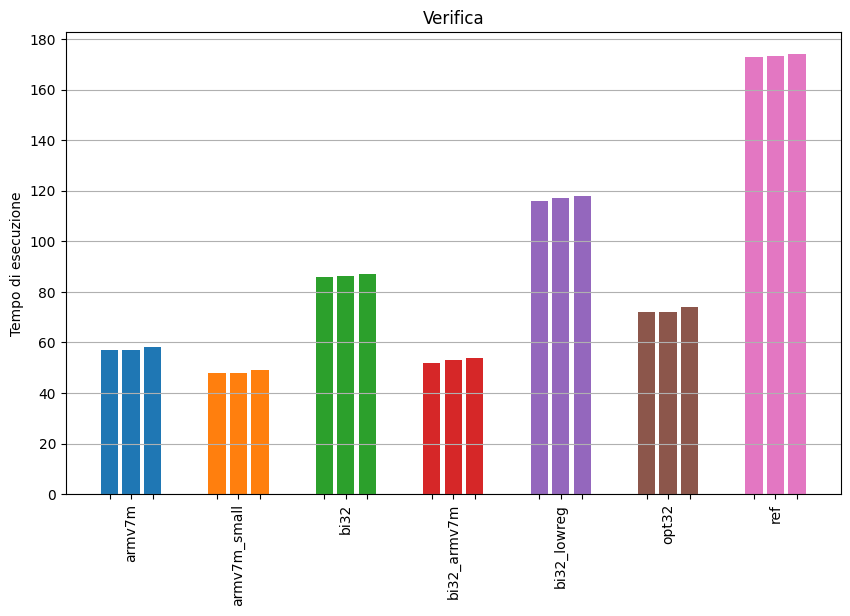

In [7]:
# Verifica tag
plotter(DATAFRAMES, "8B-V", IMPLEMENTATIONS, 20)

### PT 16 byte

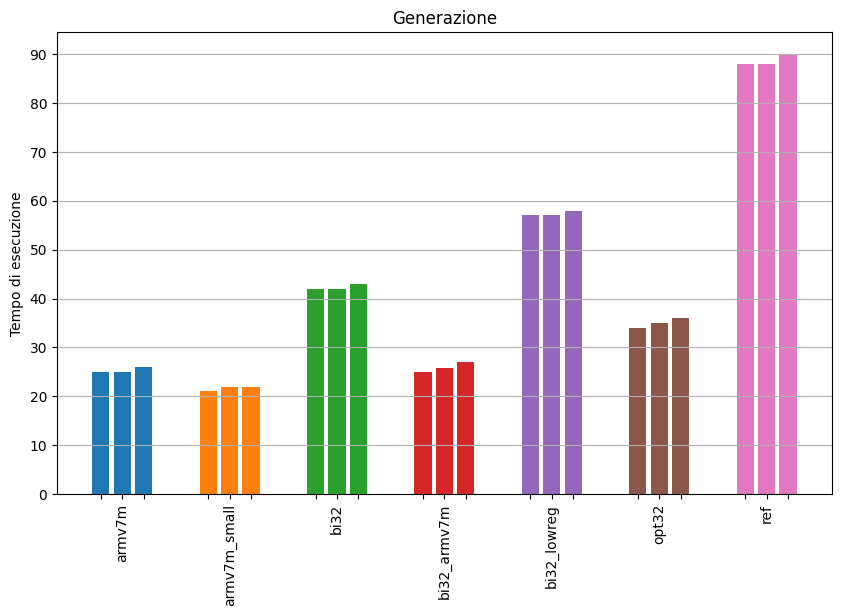

In [8]:
# Generazione tag
plotter(DATAFRAMES, "16B-A", IMPLEMENTATIONS, 10)

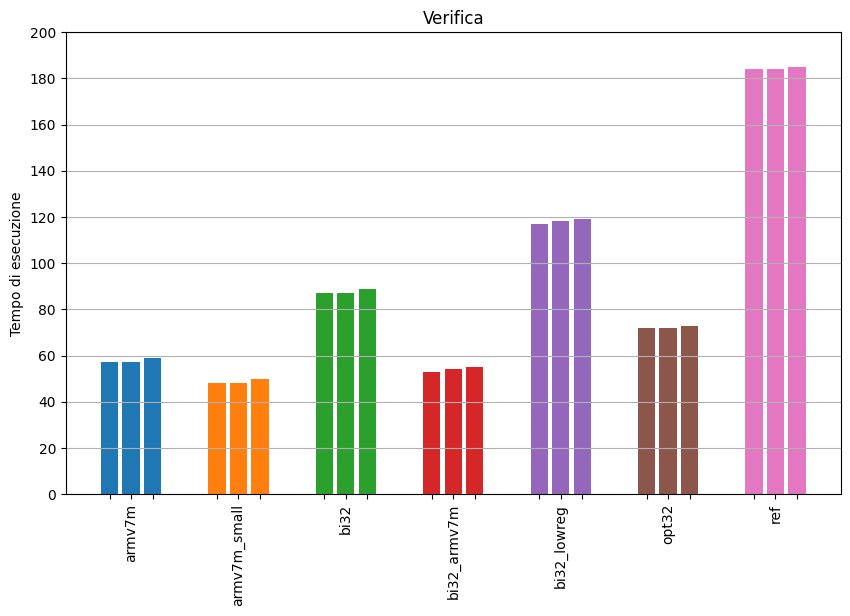

In [9]:
# Verifica tag
plotter(DATAFRAMES, "16B-V", IMPLEMENTATIONS, 20)

## Conclusioni

### Setup

In [10]:
def checker(dataframes: list, columns: list, index: int, check: FunctionType) -> None:
    for column in columns:
        test_series = dataframes[index][column]
        for i in range(len(dataframes)):
            if i == index:
                continue
            series = dataframes[i][column]
            assert check(test_series.min(), series.min())
            assert check(test_series.mean(), series.mean())
            assert check(test_series.max(), series.max())

    print("Nessuna AssertionError è stata sollevata")

In [11]:
def template(best: pd.DataFrame, worst: pd.DataFrame, columns: list, calculate: FunctionType) -> None:
    results = [[], [], []]
    for column in columns:
        best_series = best[column]
        worst_series = worst[column]
        results[0].append(calculate(best_series.min(), worst_series.min()))
        results[1].append(calculate(best_series.mean(), worst_series.mean()))
        results[2].append(calculate(best_series.max(), worst_series.max()))
    
    results = [
        [min(results[0]), max(results[0])],
        [min(results[1]), max(results[1])],
        [min(results[2]), max(results[2])]
    ]

    print(f"Rispetto alla misurazione minima: da {results[0][0]} a {results[0][1]}")
    print(f"Rispetto alla misurazione media: da {results[1][0]} a {results[1][1]}")
    print(f"Rispetto alla misurazione massima: da {results[2][0]} a {results[2][1]}")

In [12]:
def times(best: pd.DataFrame, worst: pd.DataFrame, columns: list) -> None:
    def calculate(best: int, worst: int) -> float:
        return np.around( worst/best, 2 )
    template(best, worst, columns, calculate)
    
    
def percentage_increase(best: pd.DataFrame, worst: pd.DataFrame, columns: list) -> None:
    def calculate(best: int, worst: int) -> float:
        return np.around( ((worst * 100) / best) - 100, 2 )
    template(best, worst, columns, calculate)

### Migliori implementazioni

L'implementazione `armv7m_small` è quella che ha ottenuto i tempi di esecuzione migliori in ogni possibile grandezza di PT considerata

A seguire abbiamo le implementazioni `bi32_armv7m` e `armv7m`, con tempi di esecuzione molto simili a quelli di `armv7m_small` ma leggermente peggiori

Notiamo come tutte queste implementazioni sono ottimizzate per architetture ARMv7-M

In [13]:
# Armv7m_small migliore implementazione per PT da 0 byte
for i in range(0,len(INDEX),2):
    try:
        checker(DATAFRAMES, INDEX, 1, lambda x,y : x < y)
    except AssertionError:
        print(f"Armv7m_small non domina {INDEX[i]} e {INDEX[i+1]}")
    print()

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata



### Peggiori implementazioni

L'implementazione `ref` è quella che ha ottenuto i tempi di esecuzione peggiori in ogni possibile grandezza di PT considerata

A seguire abbiamo le implementazioni `bi32_lowreg`, `opt32` e `bi32`, ma con tempi di esecuzione nettamente migliori: infatti, l'implementazione `ref` è almeno il $40$\% più lenta rispetto alla prima citata, arrivando fino al $58$\%, e circa $3.35/4.2$ volte più lenta dell'implementazione migliore

Notiamo subito come le implementazioni peggiori sono quelle che cercano di ottimizzare architetture $32$ bit generiche oppure quella priva di ottimizzazioni

In [14]:
# Ref peggiore implementazione
for i in range(0,len(INDEX),2):
    try:
        checker(DATAFRAMES, INDEX, 6, lambda x,y : x > y)
    except AssertionError:
        print(f"Ref non domina {INDEX[i]} e {INDEX[i+1]}")
    print()

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata

Nessuna AssertionError è stata sollevata



In [15]:
# Ref quante volte è peggio di armv7m_small, migliore
times(armv7m_small, ref, INDEX)

Rispetto alla misurazione minima: da 3.43 a 4.19
Rispetto alla misurazione media: da 3.44 a 4.0
Rispetto alla misurazione massima: da 3.33 a 4.09


In [16]:
# Ref quanti punti percentuali è peggio di bi32_lowreg, seconda peggiore
percentage_increase(bi32_lowreg, ref, INDEX)

Rispetto alla misurazione minima: da 40.0 a 57.26
Rispetto alla misurazione media: da 40.27 a 55.91
Rispetto alla misurazione massima: da 40.52 a 55.46


### Dimensioni eseguibile

Tutte le implementazioni testate occupano circa il $2/4$\% dello spazio disponibile